In [1]:
%env WANDB_API_KEY=ca052f00ea6de6ee4031c1b94b78629919d4191c

# General imports
import os
import json
import collections

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import scipy.sparse as sp

import torch
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from scipy.sparse import coo_matrix
import copy

from torch_geometric.utils import to_networkx

import networkx as nx
from networkx.algorithms import community

from tqdm.auto import trange

from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F
from scipy import sparse
import wandb
wandb.login()



env: WANDB_API_KEY=ca052f00ea6de6ee4031c1b94b78629919d4191c


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edesaa1. Use `wandb login --relogin` to force relogin


True

In [2]:
import pickle

with open('incongruent_graphs.pickle', 'rb') as output:
    graphs = pickle.load(output)


with open('incongruent_labels.pickle', 'rb') as output:
      label_array = pickle.load(output)


with open('incongruent_groups.pickle', 'rb') as output:
      group_array = pickle.load(output)   


In [3]:
graph1 = graphs[0]

In [4]:
unique, counts = np.unique(label_array, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 341]
 [  1 244]]


In [5]:
use_wandb = True #@param {type:"boolean"}
wandb_project = "gnn_stroop" #@param {type:"string"}
wandb_run_name = "dataset-incongruent_2L_32h" #@param {type:"string"}

if use_wandb:
    wandb.init(project=wandb_project, name=wandb_run_name)

In [6]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [7]:
from torch_geometric.data import InMemoryDataset, Data
import torch
import numpy as np

def create_pytorch_data(data_list, labels):
        data_list_pyg = []  # List to store PyG Data objects

        for graph_data, label in zip(data_list, labels):

            # Convert NumPy arrays to PyTorch tensors
            coo = coo_matrix(graph_data)

            # Extract non-zero entries as edge tuples
            edge_index = torch.tensor([np.array(coo.row), np.array(coo.col)], dtype=torch.long)

            edge_weight = torch.from_numpy(coo.data).to(torch.float32)
            y = torch.tensor(label, dtype=torch.long)  # Class for each graph

            # Create a PyG Data object for each graph in your dataset (without node features)
            data = Data(edge_index=edge_index, edge_weight=edge_weight, y=y)
            data_list_pyg.append(data)

        # Concatenate the PyG Data objects into a single Data object
        # data = collate(data_list_pyg)
        return data_list_pyg


In [8]:
# Create an instance of your custom dataset
custom_dataset = create_pytorch_data(data_list=graphs, labels = label_array)

# Access the processed PyG Data objects
data = custom_dataset[0]  # Get the first graph in the dataset
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

num_nodes = data.num_nodes


Data(edge_index=[2, 13], y=0, edge_weight=[13])
Number of nodes: 4
Number of edges: 13
Average node degree: 3.25
Has self-loops: True
Is undirected: True


/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_28200/122919934.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  edge_index = torch.tensor([np.array(coo.row), np.array(coo.col)], dtype=torch.long)
/Users/erangad/opt/miniconda3/envs/env/lib/python3.10/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'edge_weight'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [9]:
data_details = {
    "num_nodes": {data.num_nodes},
    "num_edges": {data.num_edges},
    "Is undirected": {data.is_undirected()}
}

if use_wandb:
    # Log all the details about the data to W&B.
    wandb.log(data_details) #🪄🐝
else:
    print(json.dumps(data_details, sort_keys=True, indent=4))

In [10]:
# 16 graphs * 17 partipants 
# 14 training and 3 testing

#GCN example 3   

training_graphs= 12 * 39

train_dataset = custom_dataset[:training_graphs]
test_dataset = custom_dataset[training_graphs:]

torch.manual_seed(12345)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 468
Number of test graphs: 117


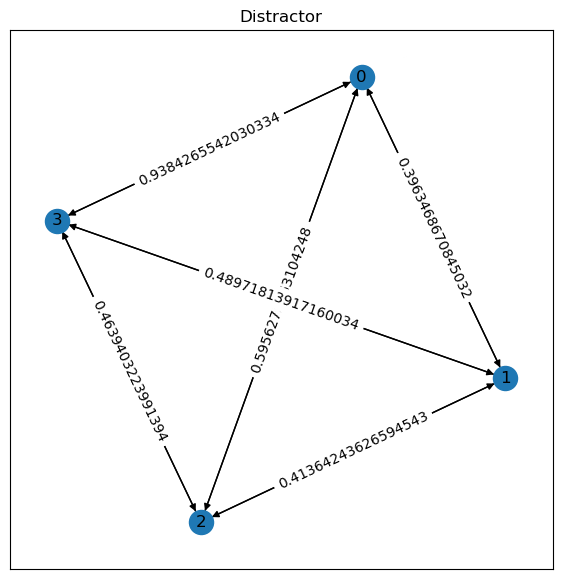

tensor(1)


In [11]:
import networkx as nx
titles =['No Distractor', 'Distractor']

graph1  = custom_dataset[10]
g = to_networkx(graph1, edge_attrs=["edge_weight"])
plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
pos= nx.spring_layout(g, seed=42)
nx.draw_networkx(g, pos=pos)
labels = nx.get_edge_attributes(g,'edge_weight')
nx.draw_networkx_edge_labels(g,pos, edge_labels=labels)
plt.title(titles[graph1.y])
plt.show()
print(graph1.y)

In [12]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 15], y=[1], edge_weight=[15], batch=[4], ptr=[2])

Step 2:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 13], y=[1], edge_weight=[13], batch=[4], ptr=[2])

Step 3:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 14], y=[1], edge_weight=[14], batch=[4], ptr=[2])

Step 4:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 14], y=[1], edge_weight=[14], batch=[4], ptr=[2])

Step 5:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 13], y=[1], edge_weight=[13], batch=[4], ptr=[2])

Step 6:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 12], y=[1], edge_weight=[12], batch=[4], ptr=[2])

Step 7:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 12], y=[1], edge_weight=[12], batch=[4], ptr=[2])

Step 8:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 12], y=[1], edge_weight=[12], batch=[4], ptr=[2])



In [13]:
import torch.nn as nn
import torch

class GCNModel(nn.Module):
    def __init__(self, num_nodes, hidden_size=32):
        super(GCNModel, self).__init__()
        self.node_embedding = nn.Embedding(num_nodes, hidden_size)
        # Initialize the embeddings with small random values
        nn.init.normal_(self.node_embedding.weight, std=0.1)
        self.conv1 = ...  # Your graph convolutional layer here

    def forward(self, edge_index, edge_attr, batch):
        x = self.node_embedding.weight
        x = self.conv1(x, edge_index, edge_attr)
        ...
        return x

In [14]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GraphConv


class GCN(torch.nn.Module):
    def __init__(self,  num_nodes, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.node_embedding = nn.Embedding(num_nodes, hidden_channels)
        # Initialize the embeddings with small random values
        nn.init.normal_(self.node_embedding.weight, std=0.1)
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, edge_index, edge_weight, batch):
         # 1. Obtain node embeddings 
        x = self.node_embedding.weight
       
        x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_weight)
        x = x.relu()
        x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_weight)
        # x = x.relu()
        # x = self.conv3(x=x, edge_index=edge_index, edge_weight=edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(num_nodes = num_nodes, hidden_channels=64, num_classes = 2)
print(model)

GCN(
  (node_embedding): Embedding(4, 64)
  (conv1): GraphConv(64, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [15]:
data
model = GCN(num_nodes = num_nodes, hidden_channels=16, num_classes = 2)
out = model(data.edge_index, data.edge_weight,  data.batch)  # Perform a single forward pass
print(out)

tensor([[-0.0880, -0.0452]], grad_fn=<AddmmBackward0>)


In [16]:
data.edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]])

In [17]:
custom_dataset[0].edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]])

In [18]:
model = GCN(num_nodes = num_nodes, hidden_channels=32, num_classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.edge_index, data.edge_weight,  data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.edge_index, data.edge_weight,  data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 300):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    wandb.log({
            "train/acc": train_acc,
            "test/acc": test_acc,
        })

wandb.finish()

Epoch: 001, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 002, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 003, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 004, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 005, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 006, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 007, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 008, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 009, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 010, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 011, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 012, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 013, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 014, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 015, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 016, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 017, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 018, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 019, Train Acc: 0.6004, Test Acc: 0.5128
Epoch: 020, Train Acc: 0.6047, Test Acc: 0.5128
Epoch: 021, Train Acc: 0.6004, Test Acc:

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test/acc,▄▄▄▄▄▄▅▅▄▅▄▅▅▇▅▇█▂▆▅▅▇▄▄▅▅▆▄▅▃▃▃▁▅▂▃▅▄▄▄
train/acc,▁▁▁▁▁▂▃▃▂▂▃▄▃▄▄▄▅▄▃▆▆▅▇▆▇▅▅▆▆▄▇▆▇▆█▆▅█▅▅
test/acc,0.49573
train/acc,0.6859


In [19]:
wandb.finish()

In [20]:
test_graph = graphs[0]
# test_graph

# r_mat_np_coo = sparse.coo_matrix(test_graph)

coo = coo_matrix(test_graph)

# Extract non-zero entries as edge tuples
edge_index = torch.tensor([np.array(coo.row), np.array(coo.col)], dtype=torch.long)
print(edge_index)
print(coo.data)

edge_attr = torch.from_numpy(coo.data).to(torch.float32)
edge_attr

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]])
[-1.11022302e-16  4.54911676e-02  2.51465435e-01  5.51392897e-01
  4.54911676e-02  2.21198307e-01  4.72674532e-01  2.51465435e-01
  2.21198307e-01  2.82254092e-01  5.51392897e-01  4.72674532e-01
  2.82254092e-01]


tensor([-1.1102e-16,  4.5491e-02,  2.5147e-01,  5.5139e-01,  4.5491e-02,
         2.2120e-01,  4.7267e-01,  2.5147e-01,  2.2120e-01,  2.8225e-01,
         5.5139e-01,  4.7267e-01,  2.8225e-01])